# Task 1 – Exploratory Data Analysis & Preprocessing

**Project:** CrediTrust Financial – Intelligent Complaint Analysis RAG Chatbot  
**Notebook:** 01_eda_preprocessing.ipynb  
**Objective:** Understand the CFPB complaints dataset, identify patterns, filter to relevant products, clean narratives, and prepare data for embedding & RAG pipeline.

**Key Goals for this notebook:**
- Load and inspect the full CFPB complaints dataset
- Analyze distributions (products, issues, narrative lengths, missing values)
- Filter to the 4–5 target product categories
- Clean consumer complaint narratives for better embeddings
- Save cleaned & filtered dataset to `data/processed/`

---

## 1. Setup & Imports

In [2]:
import sys
import os
# Add project root (one directory above "notebooks")
sys.path.append(os.path.abspath(".."))

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from pathlib import Path

from src.data_loading import load_and_filter_complaints
from src.cleaning import clean_narrative

# Set visualization style
sns.set_theme(style="whitegrid")
%matplotlib inline

In [4]:
# Setup paths
DATA_RAW = Path("../data/raw")
DATA_PROCESSED = Path("../data/processed")
file_path = DATA_RAW / "complaints.csv"

# Start Timer
start = time.time()

# --- CALL THE FUNCTION ---
df_filtered, total_rows_scanned = load_and_filter_complaints(file_path)

# Print Stats
print(f"\nFinished processing.")
print(f"Total rows scanned: {total_rows_scanned:,}")
print(f"Filtered rows: {len(df_filtered):,}")
print(f"Time taken: {(time.time() - start)/60:.1f} minutes")

# Save (The saving logic remains outside the function)
if not df_filtered.empty:
    df_filtered.to_parquet(DATA_PROCESSED / "filtered_complaints_initial.parquet", index=False)
    print("Files saved.")

Starting chunked read from complaints.csv...
Chunk   1 | scanned:   200,000 | kept:     933
Chunk   2 | scanned:   400,000 | kept:   2,184
Chunk   3 | scanned:   600,000 | kept:   4,919
Chunk   4 | scanned:   800,000 | kept:  10,330
Chunk   5 | scanned: 1,000,000 | kept:  20,260
Chunk   6 | scanned: 1,200,000 | kept:  26,180
Chunk   7 | scanned: 1,400,000 | kept:  30,976
Chunk   8 | scanned: 1,600,000 | kept:  35,494
Chunk   9 | scanned: 1,800,000 | kept:  41,879
Chunk  10 | scanned: 2,000,000 | kept:  61,350
Chunk  11 | scanned: 2,200,000 | kept:  75,347
Chunk  12 | scanned: 2,400,000 | kept:  82,474
Chunk  13 | scanned: 2,600,000 | kept:  88,795
Chunk  14 | scanned: 2,800,000 | kept:  93,643
Chunk  15 | scanned: 3,000,000 | kept:  99,747
Chunk  16 | scanned: 3,200,000 | kept: 106,472
Chunk  17 | scanned: 3,400,000 | kept: 115,117
Chunk  18 | scanned: 3,600,000 | kept: 124,315
Chunk  19 | scanned: 3,800,000 | kept: 135,113
Chunk  20 | scanned: 4,000,000 | kept: 146,100
Chunk  21 | sca

In [5]:
df_filtered = pd.read_parquet("../data/processed/filtered_complaints_initial.parquet")

In [6]:
print("Shape:", df_filtered.shape)
print("\nColumns:", df_filtered.columns.tolist())
print("\nFirst 2 rows:")
display(df_filtered.head(2))
print("\nMemory usage:", round(df_filtered.memory_usage(deep=True).sum() / 1024**2, 1), "MiB")

Shape: (462264, 9)

Columns: ['Date received', 'Product', 'Sub-product', 'Issue', 'Sub-issue', 'Consumer complaint narrative', 'Company', 'State', 'Complaint ID']

First 2 rows:


,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company,State,Complaint ID
0,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,"CITIBANK, N.A.",TX,14069121
1,2025-06-13,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,I made the mistake of using my wellsfargo debi...,WELLS FARGO & COMPANY,ID,14061897



Memory usage: 759.6 MiB


## Product distribution – after filtering

In [ ]:
print(f"Original dataset (approx): {total_rows_scanned:,} rows")
print(f"After removing empty narratives + filtering to target products: {len(df_filtered):,} rows")
print(f"→ Kept {len(df_filtered)/total_rows_scanned:.1%} of original rows")

Original dataset (approx): 9,609,797 rows
After removing empty narratives + filtering to target products: 462,264 rows
→ Kept 4.8% of original rows


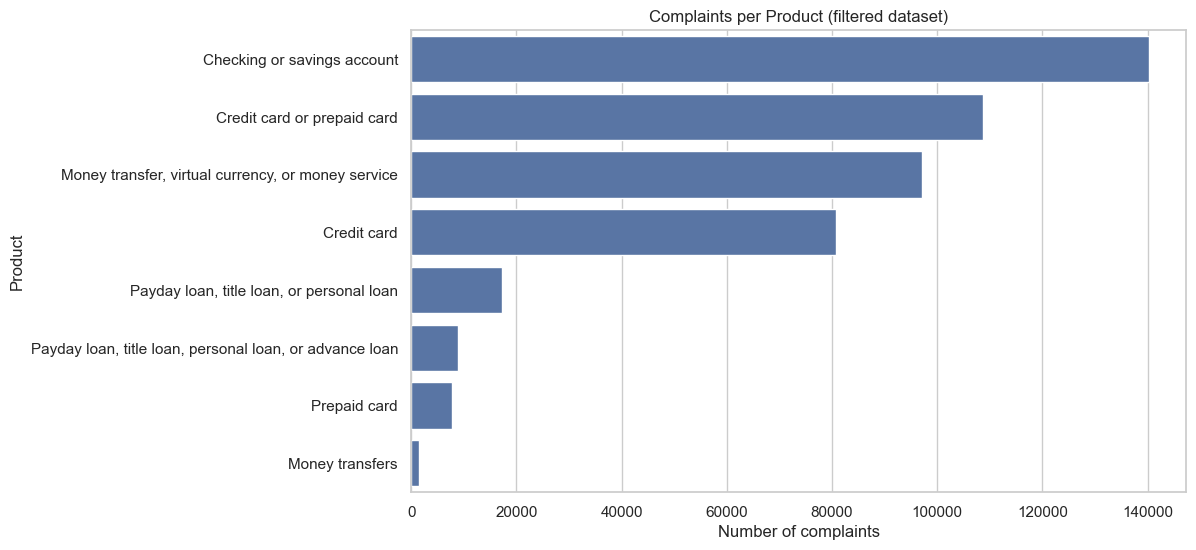

Product
Checking or savings account                                30.35
Credit card or prepaid card                                23.51
Money transfer, virtual currency, or money service         21.02
Credit card                                                17.45
Payday loan, title loan, or personal loan                   3.73
Payday loan, title loan, personal loan, or advance loan     1.92
Prepaid card                                                1.69
Money transfers                                             0.32
Name: proportion, dtype: float64


In [10]:
plt.figure(figsize=(10, 6))
order = df_filtered['Product'].value_counts().index
sns.countplot(y=df_filtered['Product'], order=order)
plt.title("Complaints per Product (filtered dataset)")
plt.xlabel("Number of complaints")
plt.show()

print(df_filtered['Product'].value_counts(normalize=True).round(4) * 100)

## Narrative length analysis (word count)

Word count statistics:
count    462264.0
mean        204.5
std         227.5
min           1.0
25%          82.0
50%         136.0
75%         253.0
max        6469.0
Name: word_count, dtype: float64


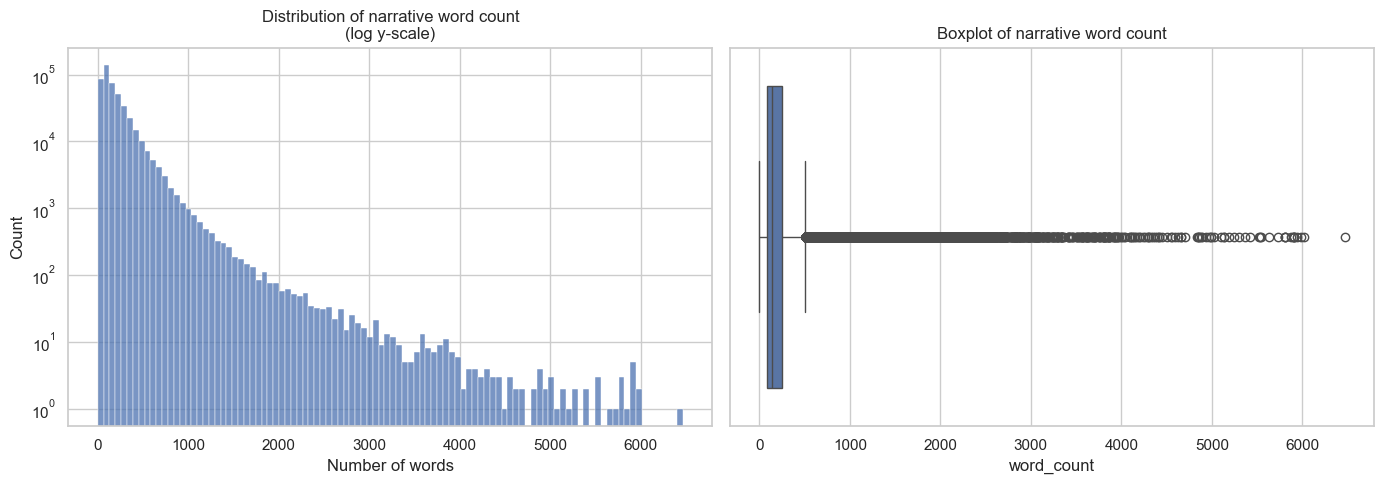

Observations:
• Median words: ~ 136
• 95th percentile: ~ 584
• Very short complaints (< 20 words): 11683
• Very long complaints (> 500 words): 32717


In [19]:
# Word count
df_filtered['word_count'] = df_filtered['Consumer complaint narrative'].str.split().str.len()

print("Word count statistics:")
print(df_filtered['word_count'].describe().round(1))

# Visuals
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
ax = sns.histplot(df_filtered['word_count'], bins=100, color='#4c72b0')
ax.set_yscale('log')
plt.title("Distribution of narrative word count\n(log y-scale)")
plt.xlabel("Number of words")

plt.subplot(1, 2, 2)
sns.boxplot(x=df_filtered['word_count'])
plt.title("Boxplot of narrative word count")

plt.tight_layout()
plt.show()

# Quick interpretation cell
print("Observations:")
print("• Median words: ~", int(df_filtered['word_count'].median()))
print("• 95th percentile: ~", int(df_filtered['word_count'].quantile(0.95)))
print("• Very short complaints (< 20 words):", (df_filtered['word_count'] < 20).sum())
print("• Very long complaints (> 500 words):", (df_filtered['word_count'] > 500).sum())

## Text cleaning

In [7]:
df_filtered['cleaned_narrative'] = df_filtered['Consumer complaint narrative'].apply(clean_narrative)
# Check the fix on a specific string
test_str = "I received notice on XX/XX/XXXX that charges were credited."
print(f"Test Fix: {clean_narrative(test_str)}")
# Output should be: "i received notice on [DATE] that charges were credited."

Test Fix: i received notice on [DATE] that charges were credited.


In [28]:
df_filtered[df_filtered['Consumer complaint narrative'].isna()]

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company,State,Complaint ID,word_count,cleaned_narrative


In [24]:
df_filtered.head(5)

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company,State,Complaint ID,word_count
0,2025-06-13,Credit card,Store credit card,Getting a credit card,Card opened without my consent or knowledge,A XXXX XXXX card was opened under my name by a...,"CITIBANK, N.A.",TX,14069121,91
1,2025-06-13,Checking or savings account,Checking account,Managing an account,Deposits and withdrawals,I made the mistake of using my wellsfargo debi...,WELLS FARGO & COMPANY,ID,14061897,109
2,2025-06-12,Credit card,General-purpose credit card or charge card,"Other features, terms, or problems",Other problem,"Dear CFPB, I have a secured credit card with c...","CITIBANK, N.A.",NY,14047085,156
3,2025-06-12,Credit card,General-purpose credit card or charge card,Incorrect information on your report,Account information incorrect,I have a Citi rewards cards. The credit balanc...,"CITIBANK, N.A.",IL,14040217,233
4,2025-06-09,Credit card,General-purpose credit card or charge card,Problem with a purchase shown on your statement,Credit card company isn't resolving a dispute ...,b'I am writing to dispute the following charge...,"CITIBANK, N.A.",TX,13968411,454


In [ ]:
df_filtered

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462264 entries, 0 to 462263
Data columns (total 10 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   Date received                 462264 non-null  object
 1   Product                       462264 non-null  object
 2   Sub-product                   443391 non-null  object
 3   Issue                         462264 non-null  object
 4   Sub-issue                     316452 non-null  object
 5   Consumer complaint narrative  462264 non-null  object
 6   Company                       462264 non-null  object
 7   State                         456826 non-null  object
 8   Complaint ID                  462264 non-null  object
 9   word_count                    462264 non-null  int64 
dtypes: int64(1), object(9)
memory usage: 35.3+ MB


In [35]:
# Satisfy the specific project deliverable
csv_path = DATA_PROCESSED / "filtered_complaints.csv"
df_filtered.to_csv(csv_path, index=False)
print(f"Saved CSV deliverable to {csv_path}")

Saved CSV deliverable to ..\data\processed\filtered_complaints.csv


### Key Findings from EDA (Task 1 Summary)

The original CFPB dataset contains approximately 9.6 million complaints. After filtering to the target product categories (Credit card, Prepaid card, Personal loan, Savings account, Money transfers) and removing entries without consumer narratives, the final dataset retains **462,264** complaints — roughly 4.8% of the original volume.

The distribution of complaints across products is led by **Checking or savings account** (30.4%), followed by **Credit card or prepaid card** (23.5%), **Money transfer/virtual currency** (21.0%), and **Credit card** (17.5%). This indicates that savings/checking and credit-related products generate the majority of narrative feedback in the filtered set.

Narrative lengths show high variability: median ~136 words, mean ~205 words, with a long tail (95th percentile ~584 words, max 6,469 words). About **11,683** complaints are very short (<20 words), while **32,717** exceed 500 words. This suggests chunking will be essential for long narratives in the RAG pipeline. Cleaning removed redactions (XXXX), standardized dates, and eliminated common boilerplate phrases, preparing the text for high-quality embeddings.